In [1]:
# LABORATORIO 6: OPTIMIZACIÓN DE REDES NEURONALES CON PYTORCH
# Dataset: Forest Cover Type - Clasificación de Tipos de Cobertura Forestal

"""
OBJETIVO: Demostrar la efectividad de diferentes optimizadores en una red neuronal
utilizando el dataset Forest Cover Type (581,012 ejemplos, 54 características)
para clasificar 7 tipos de cobertura forestal.
PROBLEMA: Predecir el tipo de árbol dominante basado en características topográficas y del suelo.
"""

# ===== IMPORTACIÓN DE BIBLIOTECAS =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

In [2]:
# Configuración de dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')
print(f'PyTorch versión: {torch.__version__}')

# Semillas para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

# ===== CARGA Y EXPLORACIÓN DEL DATASET =====
print("="*60)
print("CARGANDO DATASET FOREST COVER TYPE")
print("="*60)



Dispositivo utilizado: cpu
PyTorch versión: 2.8.0+cu126
CARGANDO DATASET FOREST COVER TYPE


In [6]:
# Montar Google Drive (para Colab)
from google.colab import drive
drive.mount('/content/drive')

# Ruta al archivo descomprimido (ajusta la ruta según tu Drive)
file_path = '/content/covtype.data'  # Asegúrate de descomprimir covtype.data.gz
df = pd.read_csv(file_path, header=None)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

# Asignar nombres a las columnas (basado en la documentación UCI)
column_names = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                'Horizontal_Distance_To_Fire_Points'] + \
               [f'Wilderness_Area_{i}' for i in range(1, 5)] + \
               [f'Soil_Type_{i}' for i in range(1, 41)] + ['Cover_Type']
df.columns = column_names

In [8]:
# Separar características y etiquetas
X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type'] - 1  # Ajustar etiquetas de 1-7 a 0-6

print(f"\n📊 INFORMACIÓN DEL DATASET:")
print(f"   Forma de X (características): {X.shape}")
print(f"   Forma de y (objetivo): {y.shape}")
print(f"   Número total de ejemplos: {X.shape[0]:,}")
print(f"   Número de características: {X.shape[1]}")




📊 INFORMACIÓN DEL DATASET:
   Forma de X (características): (581012, 54)
   Forma de y (objetivo): (581012,)
   Número total de ejemplos: 581,012
   Número de características: 54


In [9]:
# Clases
class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine',
               'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
print(f"\n🌲 CLASES DE COBERTURA FORESTAL:")
unique, counts = np.unique(y, return_counts=True)
for i, (cls, count) in enumerate(zip(class_names, counts)):
    print(f"   {i}: {cls} - {count:,} ejemplos ({count/len(y)*100:.1f}%)")



🌲 CLASES DE COBERTURA FORESTAL:
   0: Spruce/Fir - 211,840 ejemplos (36.5%)
   1: Lodgepole Pine - 283,301 ejemplos (48.8%)
   2: Ponderosa Pine - 35,754 ejemplos (6.2%)
   3: Cottonwood/Willow - 2,747 ejemplos (0.5%)
   4: Aspen - 9,493 ejemplos (1.6%)
   5: Douglas-fir - 17,367 ejemplos (3.0%)
   6: Krummholz - 20,510 ejemplos (3.5%)


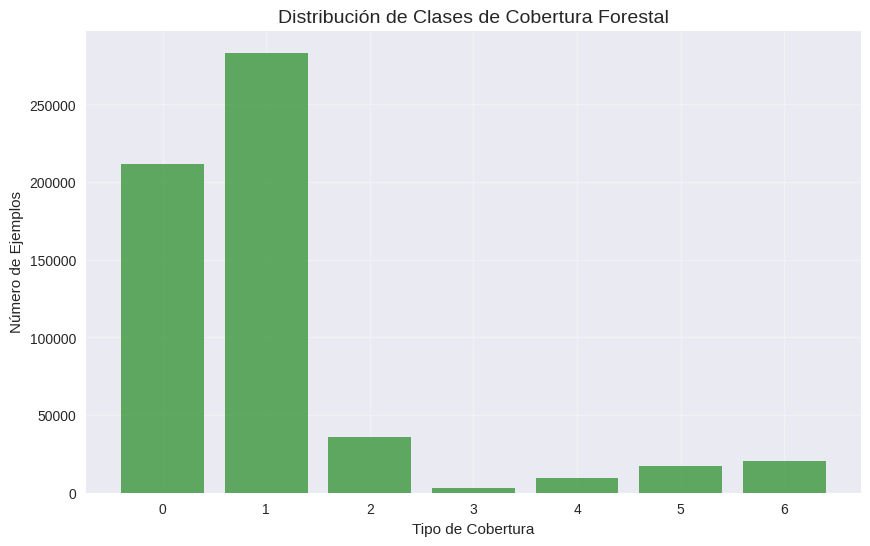

In [10]:
# Visualización básica
plt.figure(figsize=(10, 6))
plt.bar(range(len(class_names)), counts, alpha=0.7, color='forestgreen')
plt.title('Distribución de Clases de Cobertura Forestal', fontsize=14)
plt.xlabel('Tipo de Cobertura')
plt.ylabel('Número de Ejemplos')
plt.xticks(range(len(class_names)), [f'{i}' for i in range(len(class_names))])
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# ===== PREPROCESAMIENTO DE DATOS =====
print("\n" + "="*60)
print("PREPROCESAMIENTO DE DATOS")
print("="*60)

# Subconjunto para acelerar entrenamiento
n_samples = 100000
indices = np.random.choice(len(X), n_samples, replace=False)
X_subset = X.iloc[indices].values
y_subset = y.iloc[indices].values

print(f"Usando subconjunto de {n_samples:,} ejemplos para entrenamiento")


PREPROCESAMIENTO DE DATOS
Usando subconjunto de 100,000 ejemplos para entrenamiento


In [12]:
# División de datos
X_train, X_temp, y_train, y_temp = train_test_split(X_subset, y_subset, test_size=0.4, random_state=42, stratify=y_subset)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Datos de entrenamiento: {X_train.shape[0]:,}")
print(f"Datos de validación: {X_val.shape[0]:,}")
print(f"Datos de prueba: {X_test.shape[0]:,}")

Datos de entrenamiento: 60,000
Datos de validación: 20,000
Datos de prueba: 20,000


In [13]:
# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [14]:
# Tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

In [17]:
# DataLoaders
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders creados con batch_size = {batch_size}")

DataLoaders creados con batch_size = 512


In [19]:
# ===== DEFINICIÓN DE LA RED NEURONAL =====
print("\n" + "="*60)
print("DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL")
print("="*60)

class ForestCoverNet(nn.Module):
    def __init__(self, input_size=54, hidden_sizes=[256, 128, 64], num_classes=7, dropout_rate=0.3):
        super(ForestCoverNet, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.extend([nn.Linear(prev_size, hidden_size), nn.BatchNorm1d(hidden_size), nn.ReLU(), nn.Dropout(dropout_rate)])
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.network(x)

# Configuración del modelo
input_size = X_train_scaled.shape[1]
model_config = {'input_size': input_size, 'hidden_sizes': [256, 128, 64], 'num_classes': 7, 'dropout_rate': 0.3}
print(f"Configuración del modelo: {model_config}")




DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
Configuración del modelo: {'input_size': 54, 'hidden_sizes': [256, 128, 64], 'num_classes': 7, 'dropout_rate': 0.3}


In [20]:
# ===== FUNCIÓN DE ENTRENAMIENTO =====
def train_model(model, optimizer_name, optimizer, train_loader, val_loader, epochs=50):
    model.train()
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    training_times = []
    best_val_acc = 0

    print(f"\n🚀 Entrenando con optimizador: {optimizer_name}")
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(100 * train_correct / train_total)
        val_accuracies.append(100 * val_correct / val_total)
        training_times.append(time.time() - epoch_start)

        if val_accuracies[-1] > best_val_acc:
            best_val_acc = val_accuracies[-1]

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Época {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}% | "
                  f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}% | Tiempo: {training_times[-1]:.2f}s")

    total_time = time.time() - start_time
    print(f"✅ Entrenamiento completado en {total_time:.2f}s | Mejor Val Acc: {best_val_acc:.2f}%")
    return {'optimizer_name': optimizer_name, 'train_losses': train_losses, 'val_losses': val_losses,
            'train_accuracies': train_accuracies, 'val_accuracies': val_accuracies, 'best_val_acc': best_val_acc}



In [23]:
# ===== ENTRENAMIENTO CON OPTIMIZADORES =====
print("\n" + "="*80)
print("COMPARACIÓN DE OPTIMIZADORES")
print("="*80)

optimizer_configs = [
    ('SGD', lambda model: optim.SGD(model.parameters(), lr=0.01)),
    ('RMSprop', lambda model: optim.RMSprop(model.parameters(), lr=0.001)),
    ('Adam', lambda model: optim.Adam(model.parameters(), lr=0.001)),
]

results = {}
trained_models = {}
epochs = 50

for optimizer_name, optimizer_fn in optimizer_configs:
    print(f"\n{'='*20} {optimizer_name} {'='*20}")
    model = ForestCoverNet(**model_config).to(device)
    optimizer = optimizer_fn(model)
    results[optimizer_name] = train_model(model, optimizer_name, optimizer, train_loader, val_loader, epochs)
    trained_models[optimizer_name] = model

# ===== ANÁLISIS Y VISUALIZACIÓN =====
print("\n" + "="*80)
print("ANÁLISIS DE RESULTADOS")
print("="*80)

# Resumen de resultados
summary_data = [{'Optimizador': name, 'Mejor Val Acc (%)': result['best_val_acc'],
                 'Final Val Acc (%)': result['val_accuracies'][-1]} for name, result in results.items()]
summary_df = pd.DataFrame(summary_data).sort_values('Mejor Val Acc (%)', ascending=False)
print("\n📊 RESUMEN DE RESULTADOS:")
print(summary_df.to_string(index=False, float_format='%.2f'))

best_optimizer = summary_df.iloc[0]['Optimizador']
best_accuracy = summary_df.iloc[0]['Mejor Val Acc (%)']
print(f"\n🏆 MEJOR OPTIMIZADOR: {best_optimizer} con {best_accuracy:.2f}% de precisión")




COMPARACIÓN DE OPTIMIZADORES

==================== SGD ====================

🚀 Entrenando con optimizador: SGD
Época 1/50 | Train Loss: 1.5443 | Train Acc: 45.24% | Val Loss: 1.1099 | Val Acc: 62.01% | Tiempo: 2.98s
Época 10/50 | Train Loss: 0.8218 | Train Acc: 65.81% | Val Loss: 0.7169 | Val Acc: 71.21% | Tiempo: 2.02s
Época 20/50 | Train Loss: 0.7492 | Train Acc: 69.21% | Val Loss: 0.6749 | Val Acc: 72.00% | Tiempo: 2.01s
Época 30/50 | Train Loss: 0.7179 | Train Acc: 70.18% | Val Loss: 0.6550 | Val Acc: 72.37% | Tiempo: 4.78s
Época 40/50 | Train Loss: 0.6991 | Train Acc: 70.81% | Val Loss: 0.6431 | Val Acc: 72.64% | Tiempo: 2.01s
Época 50/50 | Train Loss: 0.6850 | Train Acc: 71.40% | Val Loss: 0.6338 | Val Acc: 72.96% | Tiempo: 2.21s
✅ Entrenamiento completado en 122.07s | Mejor Val Acc: 72.96%

==================== RMSprop ====================

🚀 Entrenando con optimizador: RMSprop
Época 1/50 | Train Loss: 0.8232 | Train Acc: 66.83% | Val Loss: 0.6476 | Val Acc: 72.47% | Tiempo: 2.

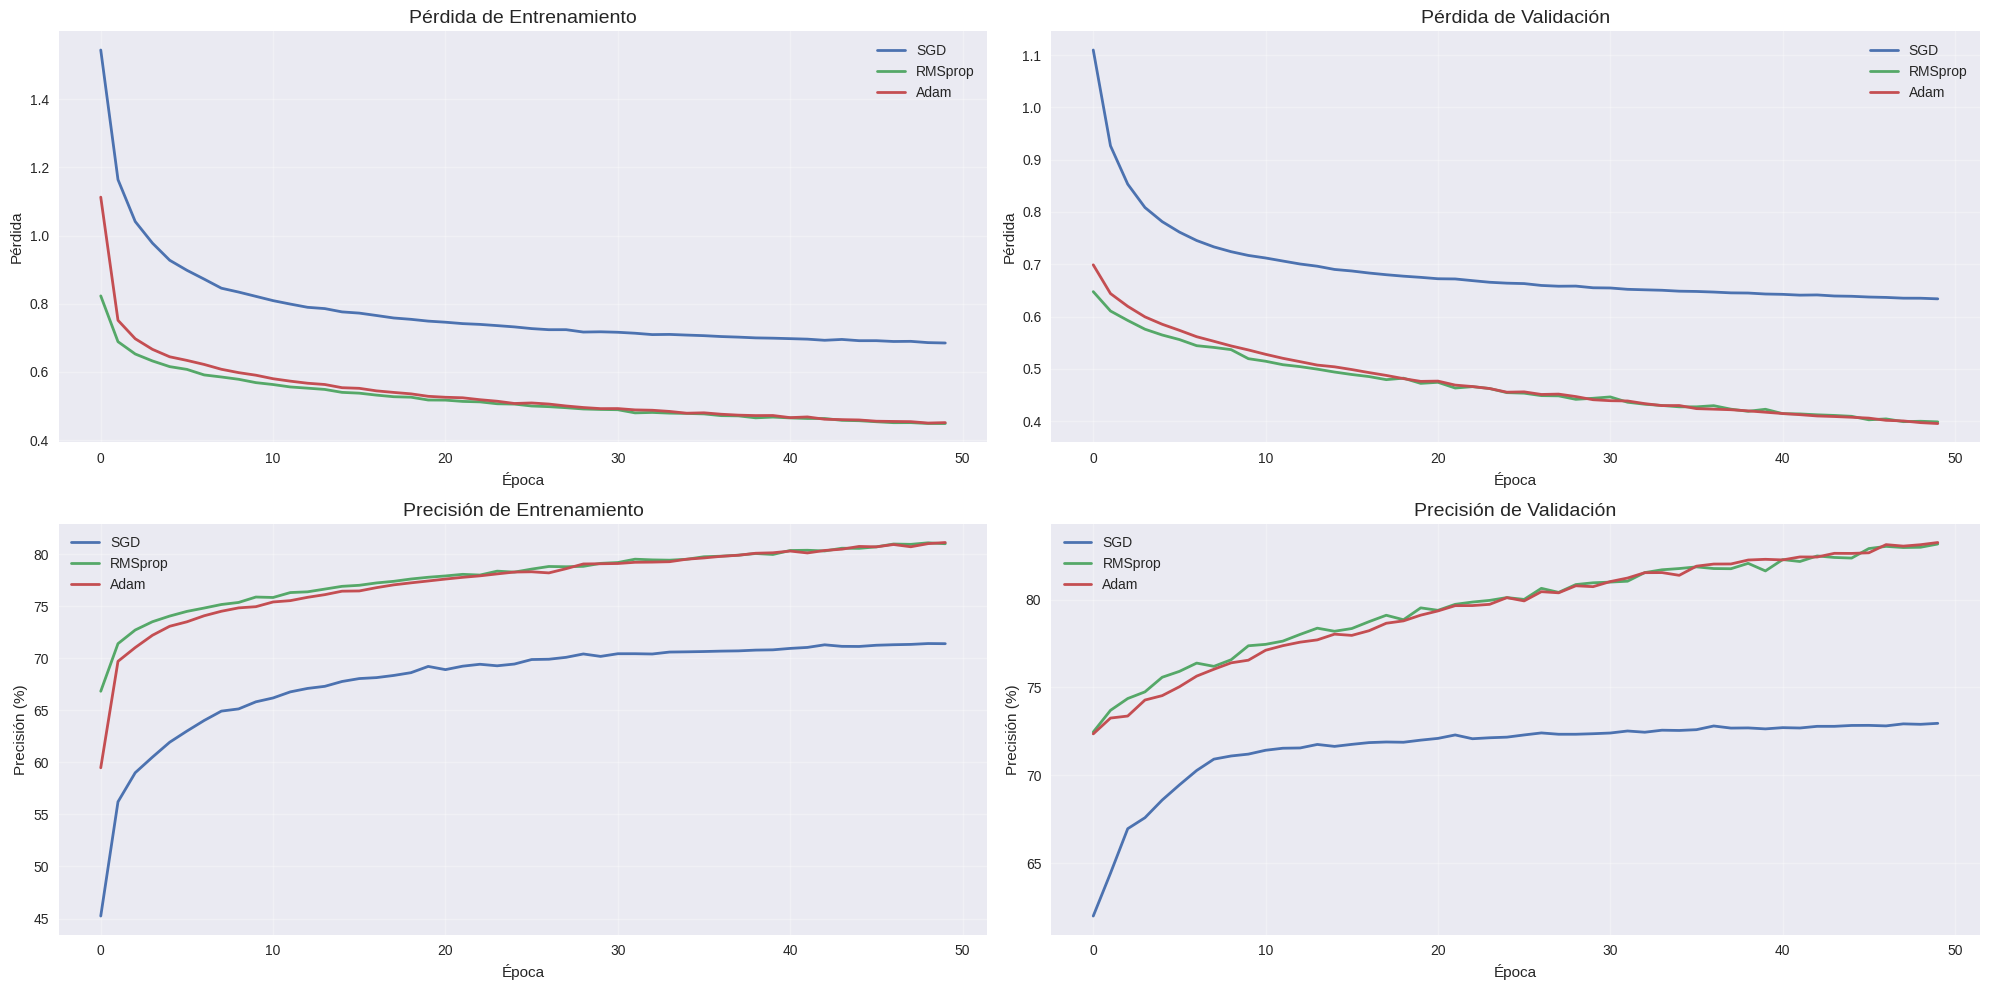

In [24]:
# Gráficos
fig = plt.figure(figsize=(20, 10))
for i, (title, metric) in enumerate([('Pérdida de Entrenamiento', 'train_losses'),
                                    ('Pérdida de Validación', 'val_losses'),
                                    ('Precisión de Entrenamiento', 'train_accuracies'),
                                    ('Precisión de Validación', 'val_accuracies')], 1):
    ax = plt.subplot(2, 2, i)
    for name, result in results.items():
        ax.plot(result[metric], label=name, linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Época')
    ax.set_ylabel('Pérdida' if 'loss' in metric else 'Precisión (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [25]:
# ===== EVALUACIÓN EN PRUEBA =====
print("\n" + "="*80)
print("EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA")
print("="*80)

def evaluate_model(model, test_loader):
    model.eval()
    test_correct, test_total = 0, 0
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            test_total += batch_y.size(0)
            test_correct += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    return 100 * test_correct / test_total, all_predictions, all_targets

best_model = trained_models[best_optimizer]
test_accuracy, predictions, targets = evaluate_model(best_model, test_loader)
print(f"\n🎯 Precisión en prueba con {best_optimizer}: {test_accuracy:.2f}%")


EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA

🎯 Precisión en prueba con Adam: 83.56%



📋 REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
                   precision    recall  f1-score   support

       Spruce/Fir     0.8742    0.7897    0.8298      7333
   Lodgepole Pine     0.8340    0.9109    0.8707      9732
   Ponderosa Pine     0.7353    0.8975    0.8084      1229
Cottonwood/Willow     0.8298    0.4382    0.5735        89
            Aspen     0.7246    0.3569    0.4783       339
      Douglas-fir     0.6445    0.4278    0.5143       589
        Krummholz     0.8440    0.7852    0.8135       689

         accuracy                         0.8356     20000
        macro avg     0.7838    0.6580    0.6984     20000
     weighted avg     0.8356    0.8356    0.8315     20000



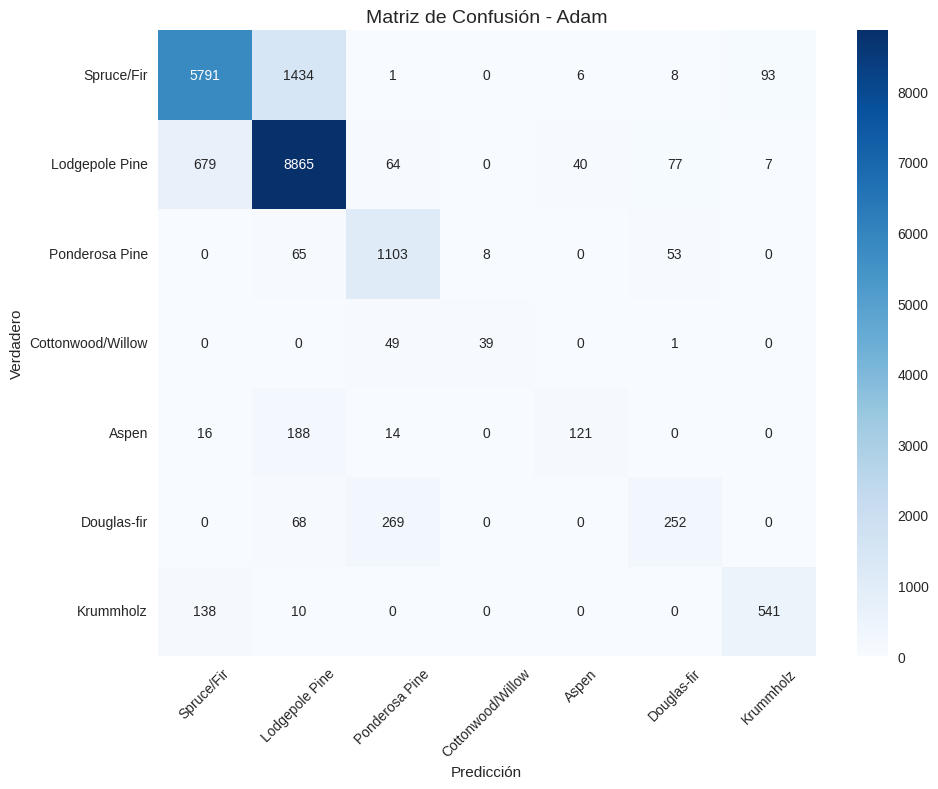

In [26]:
# Reporte y matriz de confusión
print(f"\n📋 REPORTE DE CLASIFICACIÓN:")
print("-" * 60)
print(classification_report(targets, predictions, target_names=class_names, digits=4))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(targets, predictions), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Matriz de Confusión - {best_optimizer}', fontsize=14)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [28]:
# ===== CONCLUSIONES =====
print("\n" + "="*80)
print("CONCLUSIONES")
print("="*80)
print(f"""
• Mejor optimizador: {best_optimizer} ({best_accuracy:.2f}% precisión)
• Precisión en prueba: {test_accuracy:.2f}%
• Recomendación: Usar Adam para problemas similares por estabilidad y rapidez.
""")


CONCLUSIONES

• Mejor optimizador: Adam (83.24% precisión)
• Precisión en prueba: 83.56%
• Recomendación: Usar Adam para problemas similares por estabilidad y rapidez.

